In [33]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from class_models import early_stop
import time
from torch.optim.lr_scheduler import StepLR

In [2]:
# setting device and reproducibility
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print(f"Using device: {device}")

Using device: cpu


## Learning schedule to find the best learning rate using *ReduceOnPlateau* scheduler
The learning rate scheduler (ReduceLROnPlateau) adjusts the learning rate based on validation loss. The use of ReduceLROnPlateau scheduler helps in adjusting the learning rate dynamically based on the validation loss, which can improve the training process. 

- This training task tracks the best model in the k-fold. 
- The best model is tracked by comparing the validation loss of each epoch. 
- The learning rate (best_lr) that resulted in the lowest validation loss is recorded.

In [3]:
# import data 
data_frame = pd.read_csv("data/NYCTaxiFares.csv", na_values=["NA", "?"])

In [4]:
# function to calculate the distance of the travel
def haversine_distance(dat_f, lat1, lon1, lat2, lon2):
    
    # average radius of the Earth in (km)
    r = 6371
    
    phi1 = np.radians(dat_f[lat1])
    phi2 = np.radians(dat_f[lat2])
    delta_phi = np.radians(dat_f[lat2] - dat_f[lat1])
    delta_lambda = np.radians(dat_f[lon2] - dat_f[lon1])
    
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c)
    
    return d

def preprocessing(df_n, cat_cols):
    """
    Preprocesses the data and adds pandas categorical fields to a dataframe.
    :param df_n: pandas dataframe 
    :param cat_cols: list of categorical fields
    :return: pandas dataframe
    """
    # append a 'dist_km' new feature in the dataframe
    df_n['dist_km'] = haversine_distance(df_n, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
    
    # remove outliers
    dfd = df_n[(df_n['fare_amount'] != 49.57) & (df_n['fare_amount'] != 45.00)].copy()
    
    # convert to pd datetime
    dfd['pickup_datetime'] = pd.to_datetime(dfd['pickup_datetime'])
    
    # Correcting pickup_datetime due to daylight savings time (April)
    dfd['EDTdate'] = dfd['pickup_datetime'] - pd.Timedelta(hours=4)
    
    # create new time fields
    dfd['Hour'] = dfd['EDTdate'].dt.hour
    dfd['AMorPM'] = np.where(dfd['Hour']<12, 'am', 'pm')
    dfd['Weekday'] = dfd['EDTdate'].dt.strftime("%a")
    
    # transform to pandas categorical variables
    for cat in cat_cols:
        dfd[cat] = dfd[cat].astype('category')
    
    dfd = dfd.drop(columns=['pickup_datetime'])
    
    return dfd

def model_tensors(df, cat_cols, cont_cols, y_col):
    """
    Get categorical, continuous and label tensors for the model
    :param df: pd dataframe
    :param cat_cols: list of categorical fields
    :param cont_cols: list of continuous fields
    :param y_col: list with the labels
    :return: cats, conts, y tensors
    """
    
    # group the data in categorical continuous and target label    
    cats = np.stack([df[col].cat.codes.values for col in cat_cols], axis=1)
    conts = np.stack([df[col].values for col in cont_cols], axis=1)
    y = df[y_col].values.reshape(-1, 1)

    # Convert to PyTorch tensors
    cats_t = torch.tensor(cats, dtype=torch.int64).to(device)
    conts_t = torch.tensor(conts, dtype=torch.float32).to(device)
    y_t = torch.tensor(y, dtype=torch.float32).to(device)
    
    return cats_t, conts_t, y_t

def create_embedding_sizes(df, cat_cols):
    """
    Create embedding sizes for PyTorch embedding layers
    :param df: pandas dataframe
    :param cat_cols: list of categorical fields
    :return: emb_sizes list
    """
    # categorical sizes list
    cat_sizes = [len(df[col].cat.categories) for col in cat_cols]

    # embedding sizes list (divide the number of unique entries in each column by two, if the result is greater than 50 select 50)
    emb_sizes = [(size, min(50,(size+1)//2)) for size in cat_sizes]
    
    return emb_sizes



In [5]:
df = preprocessing(data_frame, ['Hour', 'AMorPM', 'Weekday'])

cats, conts, y = model_tensors(df, ['Hour', 'AMorPM', 'Weekday'], ['dist_km', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], ['fare_amount'])

# number of continuous fields of the conts tensor
n_cont = conts.shape[1]

emb_sizes = create_embedding_sizes(df, ['Hour', 'AMorPM', 'Weekday'])

### Model definition

In [11]:
# Define the model
class TabularModel(nn.Module):
    def __init__(self, emb_sizes, n_cont, out_size, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_sizes])
        self.emb_drop = nn.Dropout(p)
        self.batch_norm_cont = nn.BatchNorm1d(n_cont)

        layer_list = []
        n_emb = sum([nf for ni, nf in emb_sizes])
        n_in = n_emb + n_cont
        for i in layers:
            layer_list.append(nn.Linear(n_in, i))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(i))
            layer_list.append(nn.Dropout(p))
            n_in = i

        layer_list.append(nn.Linear(layers[-1], out_size))
        self.layers = nn.Sequential(*layer_list)

    def forward(self, x_cat, x_cont):
        embeddings = [e(x_cat[:, i]) for i, e in enumerate(self.embeds)]
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.batch_norm_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

### K-folds function generator
Since the *train_index* and the *val_index* are those who effectively creates the training subsets we can create all the six subsets: 2 for categorical, 2 for continuous and 2 for y labels.

In [12]:
def get_train_test(categoricals, continuous, y_train, test_size=0.2):
    # Ensure the input arrays have the same number of rows
    assert categoricals.shape[0] == continuous.shape[0] == y_train.shape[0], "Input arrays must have the same number of rows"

    # Combine the data into a single array for splitting
    combined = np.hstack((categoricals, continuous, y_train))

    # Split the combined data into train and test sets
    train_data, test_data = train_test_split(combined, test_size=test_size, random_state=42)

    # Determine the number of categorical and continuous columns
    n_cat_cols = categoricals.shape[1]
    n_cont_cols = continuous.shape[1]

    # Separate the train and test data back into categorical, continuous, and target tensors

    # selects all rows and the first n_cat_cols columns (categorical features).
    cat_train = torch.tensor(train_data[:, :n_cat_cols], dtype=torch.int64).to(device)

    # selects all rows and the columns from n_cat_cols to n_cat_cols + n_cont_cols (continuous features).
    con_train = torch.tensor(train_data[:, n_cat_cols:n_cat_cols + n_cont_cols], dtype=torch.float32).to(device)

    # selects all rows and the last column (target labels).
    y_train = torch.tensor(train_data[:, -1], dtype=torch.float32).unsqueeze(1).to(device)

    cat_test = torch.tensor(test_data[:, :n_cat_cols], dtype=torch.int64).to(device)
    con_test = torch.tensor(test_data[:, n_cat_cols:n_cat_cols + n_cont_cols], dtype=torch.float32).to(device)
    y_test = torch.tensor(test_data[:, -1], dtype=torch.float32).unsqueeze(1).to(device)

    return cat_train, con_train, y_train, cat_test, con_test, y_test

cat_train, con_train, y_train, cat_test, con_test, y_test = get_train_test(cats, conts, y)

### Model and training parameters
With the aim of contrast the performance of the learning with a constant learning rate vs the performance of the training with a learning rate schedule  

In [13]:
# model instance (output_size = 1 for regression task)
model = TabularModel(emb_sizes, conts.shape[1], 1, [400, 300, 200, 100], p=0.4).to(device)
print(model.layers)

Sequential(
  (0): Linear(in_features=22, out_features=400, bias=True)
  (1): ReLU(inplace=True)
  (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.4, inplace=False)
  (4): Linear(in_features=400, out_features=300, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.4, inplace=False)
  (8): Linear(in_features=300, out_features=200, bias=True)
  (9): ReLU(inplace=True)
  (10): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.4, inplace=False)
  (12): Linear(in_features=200, out_features=100, bias=True)
  (13): ReLU(inplace=True)
  (14): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Dropout(p=0.4, inplace=False)
  (16): Linear(in_features=100, out_features=1, bias=True)
)


In [14]:
# criteria
criterion = nn.SmoothL1Loss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=20, gamma=0.90)

# TensorDatasets
train_dataset = TensorDataset(cat_train, con_train, y_train)
test_dataset = TensorDataset(cat_test, con_test, y_test)

batch_size = 128

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# early stop 
early_stopping = early_stop.EarlyStopping(patience=40)

# results
results = []

def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

train_schedule = [
    "LR Scheduler",
    "No Scheduler"
]

### Exploratory training loops to get the best learning rate configuration

In [15]:
# Training loop
epochs = 120
start_time = time.time()

for mode in train_schedule:
    print(f"Training mode: {mode}")
    # restart optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # restart learning rate scheduler
    scheduler = StepLR(optimizer, step_size=20, gamma=0.90)
    # reset model parameters
    model.apply(reset_weights)
    # reset early stop
    early_stopping = early_stop.EarlyStopping(patience=40)
    for epoch in range(epochs):
        
        train_losses = []
        val_losses = []
        
        model.train()
        epoch_losses = []
        for cat_batch, con_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(cat_batch, con_batch).flatten()
            loss = torch.sqrt(criterion(y_pred, y_batch.flatten()))  # Use y_batch.flatten() here
            epoch_losses.append(loss.item())
            loss.backward()
            optimizer.step()
    
        train_losses.append(np.mean(epoch_losses))
    
        # Validation
        model.eval()
        with torch.no_grad():
            epoch_val_loss = []
            for cat_batch, con_batch, y_batch in test_loader:
                y_val = model(cat_batch, con_batch).flatten()
                val_loss = torch.sqrt(criterion(y_val, y_batch.flatten()))  # Use y_batch.flatten() here
                epoch_val_loss.append(val_loss.item())
    
            val_losses.append(np.mean(epoch_val_loss))
    
        if epoch % 5 == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch + 1}/{epochs}, T. Loss: {train_losses[-1]:.4f}, V. Loss: {val_losses[-1]:.4f}, Early S: {early_stopping.status}, Actual LR: {optimizer.param_groups[0]["lr"]:.6f}' )
        
        results.append({
            "Mode": mode,
            "Learning Rate": scheduler.get_last_lr()[0],
            "Epoch": epoch + 1,
            "Train Loss": train_losses[-1],
            "Validation Loss": val_losses[-1],
        })
        
        if mode == "LR Scheduler":
            scheduler.step()
        
        # Check early stopping
        if early_stopping(model, val_losses[-1]):  # Pass the latest validation loss to early stopping
            print(early_stopping.status)
            break
    
    print(f'Training completed in {time.time() - start_time:.2f} seconds')

Training mode: LR Scheduler
Epoch 1/120, T. Loss: 1.2826, V. Loss: 1.0300, Early S: , Actual LR: 0.010000
Epoch 6/120, T. Loss: 1.1011, V. Loss: 0.9593, Early S: NO improvement in the last 2 epochs, Actual LR: 0.010000
Epoch 11/120, T. Loss: 1.0793, V. Loss: 0.9599, Early S: NO improvement in the last 4 epochs, Actual LR: 0.010000
Epoch 16/120, T. Loss: 1.0755, V. Loss: 0.9532, Early S: NO improvement in the last 2 epochs, Actual LR: 0.010000
Epoch 21/120, T. Loss: 1.0634, V. Loss: 0.9669, Early S: NO improvement in the last 4 epochs, Actual LR: 0.009000
Epoch 26/120, T. Loss: 1.0633, V. Loss: 0.9746, Early S: NO improvement in the last 1 epochs, Actual LR: 0.009000
Epoch 31/120, T. Loss: 1.0596, V. Loss: 0.9376, Early S: NO improvement in the last 2 epochs, Actual LR: 0.009000
Epoch 36/120, T. Loss: 1.0660, V. Loss: 0.9747, Early S: NO improvement in the last 4 epochs, Actual LR: 0.009000
Epoch 41/120, T. Loss: 1.0521, V. Loss: 0.9303, Early S: NO improvement in the last 9 epochs, Act

In [27]:
# correcting the results list
def remove_brackets(res):
    res['Learning Rate'] = res['Learning Rate'][0]
    return res

corr_results = list(map(remove_brackets, results))
print(corr_results[0])

{'Mode': 'LR Scheduler', 'Learning Rate': 0.01, 'Epoch': 1, 'Train Loss': 1.2825952216520322, 'Validation Loss': 1.030048168154173}


In [28]:
results_df = pd.DataFrame(corr_results)

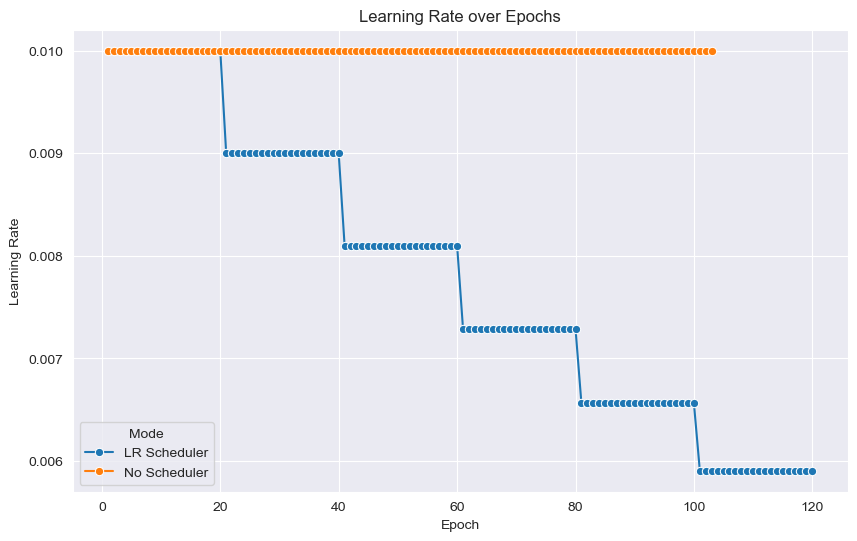

In [34]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Epoch', y='Learning Rate', hue='Mode', marker='o')
plt.title('Learning Rate over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend(title='Mode')
plt.grid(True)
plt.show()

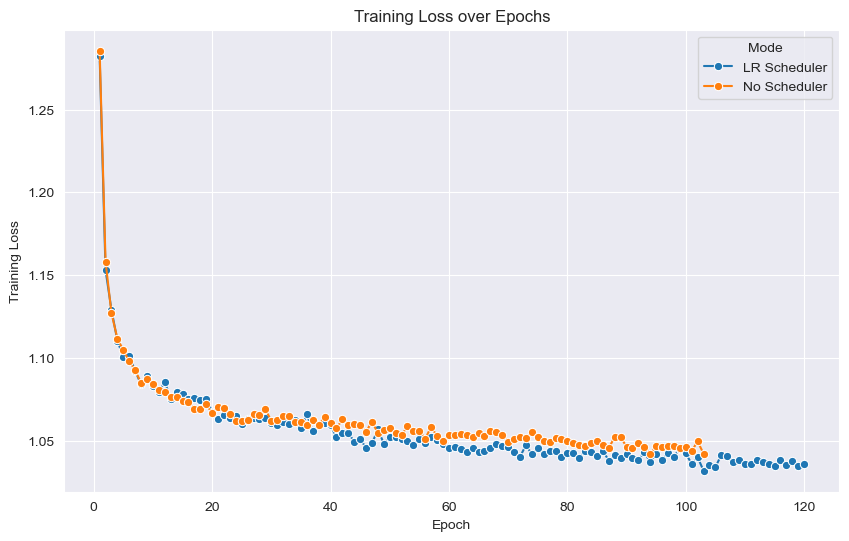

In [35]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Epoch', y='Train Loss', hue='Mode', marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(title='Mode')
plt.grid(True)
plt.show()

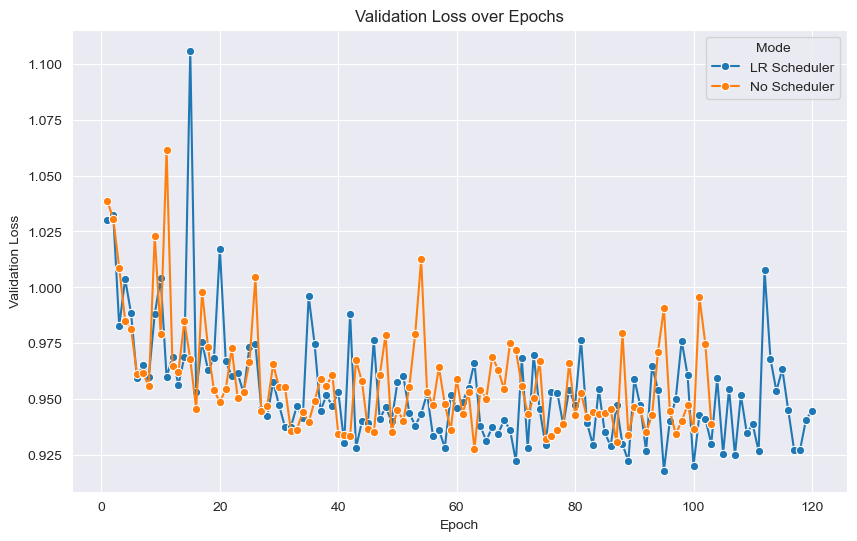

In [36]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Epoch', y='Validation Loss', hue='Mode', marker='o')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(title='Mode')
plt.grid(True)
plt.show()

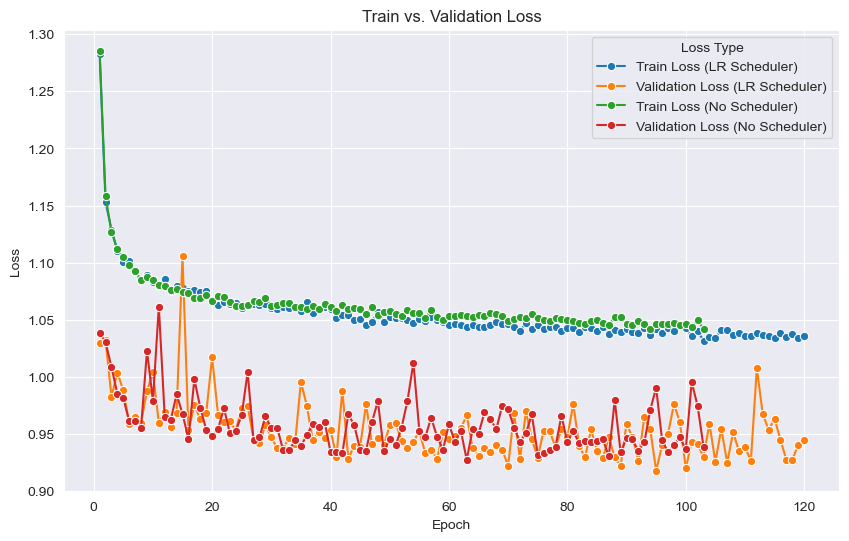

In [37]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df[results_df['Mode'] == 'LR Scheduler'], x='Epoch', y='Train Loss', label='Train Loss (LR Scheduler)', marker='o')
sns.lineplot(data=results_df[results_df['Mode'] == 'LR Scheduler'], x='Epoch', y='Validation Loss', label='Validation Loss (LR Scheduler)', marker='o')
sns.lineplot(data=results_df[results_df['Mode'] == 'No Scheduler'], x='Epoch', y='Train Loss', label='Train Loss (No Scheduler)', marker='o')
sns.lineplot(data=results_df[results_df['Mode'] == 'No Scheduler'], x='Epoch', y='Validation Loss', label='Validation Loss (No Scheduler)', marker='o')
plt.title('Train vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Loss Type')
plt.grid(True)
plt.show()

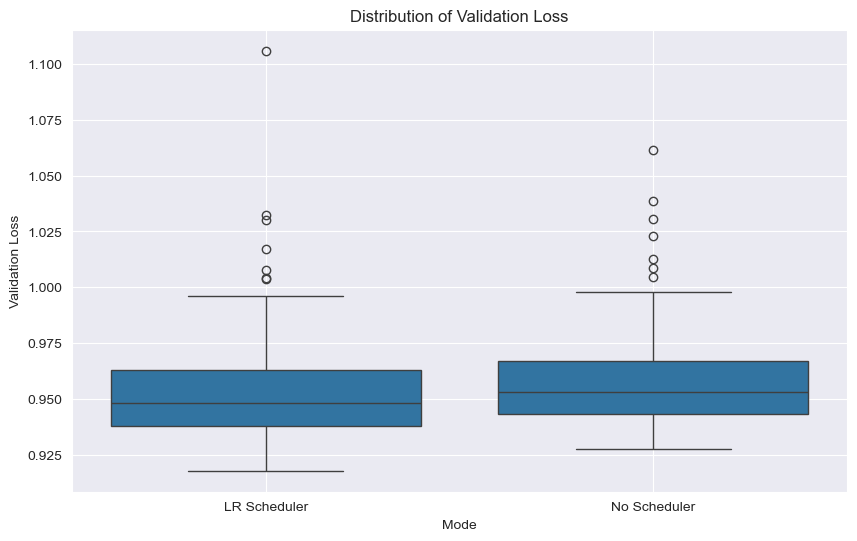

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='Mode', y='Validation Loss')
plt.title('Distribution of Validation Loss')
plt.xlabel('Mode')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()

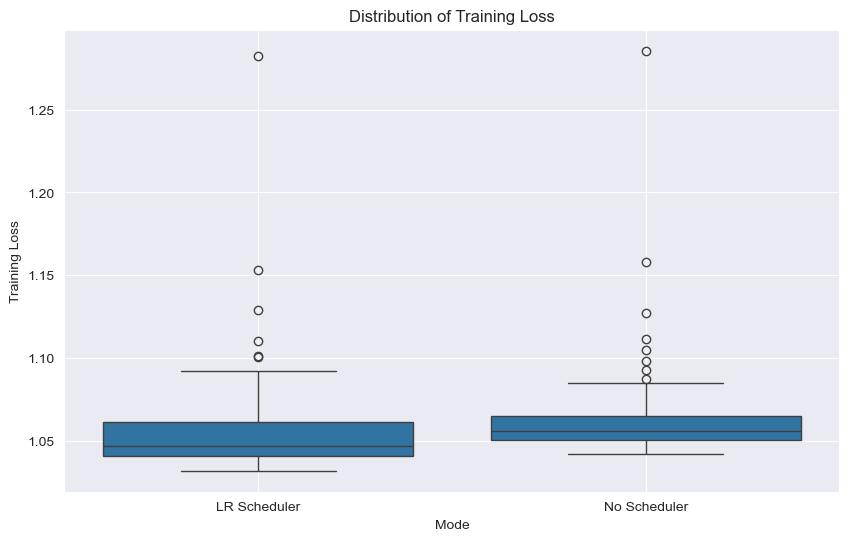

In [41]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='Mode', y='Train Loss')
plt.title('Distribution of Training Loss')
plt.xlabel('Mode')
plt.ylabel('Training Loss')
plt.grid(True)
plt.show()